# Poisson's equation 

As an example of a multi-dimensional boundary value problem, let's try to solve Poisson's equation

$$\nabla^2 V(\vec{r}) = \rho(\vec{r})$$

(or Laplace's equation for $\rho=0$) with either $V$ or $\vec{\nabla} V$ specified on the boundary. 

First we can finite-difference the equation. In 2D, with grid points labelled by $(i,j)$ this gives

$${V_{i+1,j}-2V_{i,j}+V_{i-1,j}\over h^2} + {V_{i,j+1}-2V_{i,j}+V_{i,j-1}\over h^2} = \rho_{i,j}$$

where we set the grid spacing to $h$ in both directions for simplicity. Collecting terms,

$$V_{i+1,j}+V_{i-1,j} + V_{i,j+1}+V_{i,j-1}  -4V_{i,j}  = h^2\rho_{i,j}$$

or

$$V_{i,j} = {V_{i+1,j}+V_{i-1,j} + V_{i,j+1}+V_{i,j-1}\over 4} - {h^2\rho_{i,j}\over 4}.$$(laplace)

There are a few different ways we can try to solve this.

## Relaxation: Jacobi and Gauss-Seidel

Equation {eq}`laplace` shows that $V_{i,j}$ is the average of $V$ on the neighbouring grid cells plus an extra term from the charge density. This suggests a simple algorithm that we could use to relax to a solution from a starting guess:

$$V^{n+1}_{i,j} = {1\over 4}\left(V^n_{i+1,j}+V^n_{i-1,j} + V^n_{i,j+1}+V^n_{i,j-1}\right) - {1\over 4}h^2\rho_{i,j}.$$

There are two versions of this in which you either apply this rule to the whole grid, i.e use the values $\{V^n\}$ on the right hand side to update all the grid points (Jacobi method) or you update one grid cell at a time and use the new values $V^{n+1}_{i,j}$ on the right hand side when updating neighbouring cells (Gauss-Seidel method). The second method converges a factor of 2 faster (see the discussion in Numerical Recipes section 19.5). 

As an example, let's solve the 2D potential around a circular conductor, with $V=1$ on the conductor and $V=0$ at the boundaries. (We'll take $\rho=0$ so this is Laplace's equation).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time

In [2]:
def set_bcs(n):
    # Create a mask to set the boundary points
    mask = np.zeros([n,n],dtype='bool')
    x = np.linspace(-1,1,n)
    xsqr = np.outer(x**2,np.ones(n))
    rsqr = xsqr+xsqr.T
    R = 0.1
    mask[rsqr<R**2] = True
    mask[:,0] = True
    mask[0,:] = True
    mask[-1,:] = True
    mask[:,-1] = True
    bc = np.zeros([n,n])
    bc[rsqr<R**2] = 1.0
    return mask, bc

def laplace(mask, bc, niter, V, make_plot=True):
        
    deltaV = np.zeros(niter)
    t0 = time.time()
    for i in range(niter):
        Vnew = 0.25 * (np.roll(V,1,0) + np.roll(V,-1,0) + 
                       np.roll(V,1,1) + np.roll(V,-1,1))
        deltaV[i] = np.max(np.abs(Vnew[mask == False]-V[mask == False]))
        V = Vnew
        V[mask] = bc[mask]

        if i%1000 == 0 and make_plot:
            n = len(V[0,:])
            plt.plot(np.arange(n), V[n//2,:])

    print('%d iterations took %lg seconds' %(niter, time.time()-t0))

    return V, deltaV

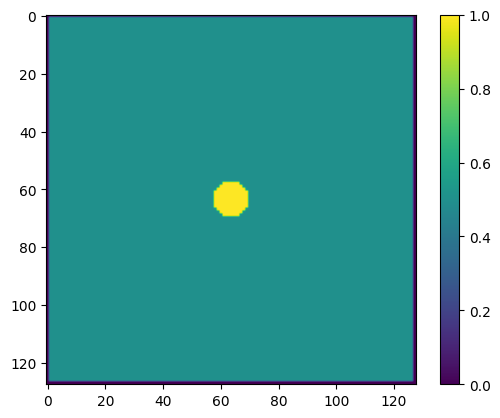

32768 iterations took 3.01018 seconds


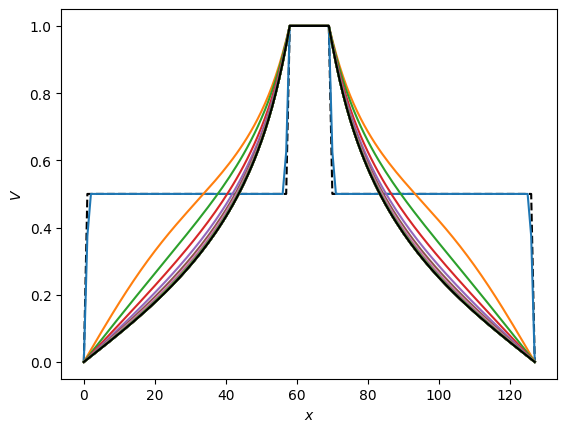

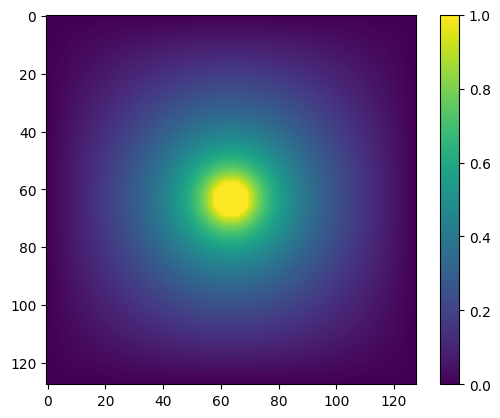

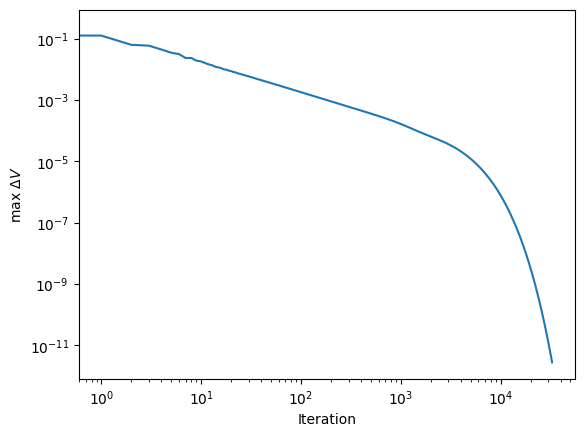

In [3]:
# Solve Laplace's equation with Jacobi method
n = 128
mask, bc = set_bcs(n)

# Initial guess for the potential 
V = np.zeros([n,n]) + 0.5
V[mask] = bc[mask]

plt.imshow(V)
plt.colorbar()
plt.show()
plt.clf()
plt.plot(np.arange(n), V[int(n/2),:], 'k--')
plt.ylabel(r'$V$')
plt.xlabel(r'$x$')

V_jacobi, deltaV_jacobi = laplace(mask, bc, 2*n*n, V)
    
plt.plot(np.arange(n), V_jacobi[int(n/2),:], 'k')
plt.show()

plt.clf()
plt.imshow(V_jacobi)
plt.colorbar()
plt.show()

plt.clf()
plt.plot(np.arange(len(deltaV_jacobi)), deltaV_jacobi)
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'max $\Delta V$')
plt.xlabel('Iteration')
plt.show()

If you want to have some fun, try changing the boundary conditions, e.g. a plane-parallel capacitor:

In [4]:
def set_bcs_capacitor(n):
    mask = np.zeros([n,n],dtype='bool')
    x1 = 3*n//8
    x2 = n-x1
    mask[:, x2] = True
    mask[:, x1] = True
    bc = np.zeros([n,n])
    bc[mask] = 1.0
    mask[:,0] = True
    mask[0,:] = True
    mask[-1,:] = True
    mask[:,-1] = True
    return mask, bc

## Multigrid method

In [5]:
# Visualize matrices as a color map
def plot_matrices(A,titles=[],nmax=4):
    n = len(A)
    if titles==[]:
        titles = [""]*n
    if n>nmax:
        nx = nmax
    else:
        nx = n
    for j in range(int(np.floor(n/nmax))+1):        
        plt.clf()
        plt.figure(figsize=(nx*4,4))
        jmax = nmax*(j+1)
        if jmax > n:
            jmax = n
        for i,AA in enumerate(A[nmax*j:jmax]):
            plt.subplot(1, nx, i+1)
            plt.imshow(AA)
            plt.colorbar()
            plt.title(titles[nmax*j + i])
        plt.show()

In [6]:
# A simple way to decrease or increase the number of grid points by a factor of 2
# From https://github.com/sievers/phys512-2022/tree/master/pdes

def deres(map):
    tmp=np.maximum(map[::2,::2],map[1::2,::2])
    tmp=np.maximum(tmp,map[::2,1::2])
    tmp=np.maximum(tmp,map[1::2,1::2])
    return tmp

def upres(map):
    n=map.shape[0]
    tmp=np.zeros([2*n,2*n])
    tmp[::2,::2]=map
    tmp[1::2,::2]=map
    tmp[::2,1::2]=map
    tmp[1::2,1::2]=map
    return tmp

<Figure size 640x480 with 0 Axes>

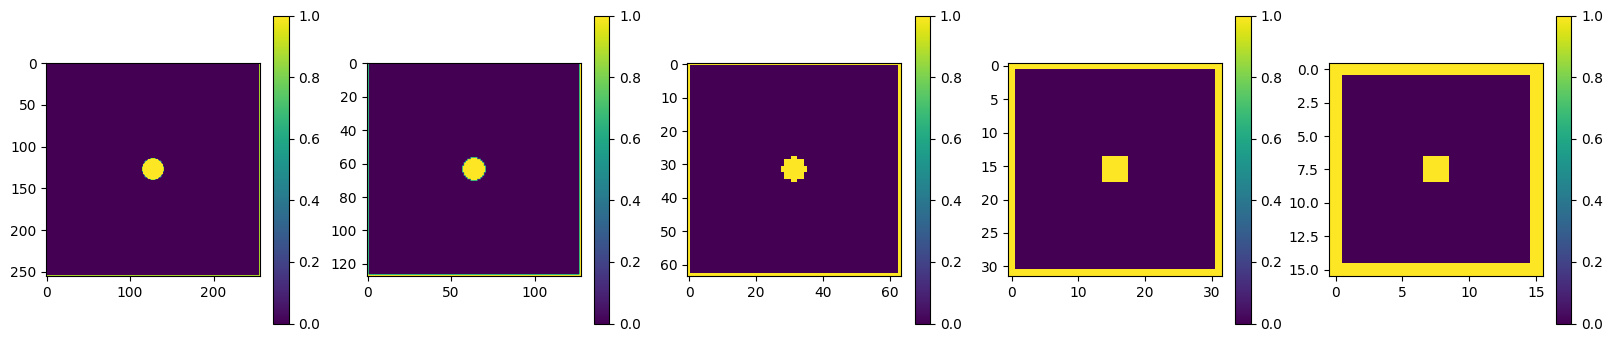

<Figure size 640x480 with 0 Axes>

<Figure size 2000x400 with 0 Axes>

In [7]:
n = 256
mask, bc = set_bcs(n)

masks = [None] * 5
masks[0] = mask

for i in range(1,5):
    masks[i] = deres(masks[i-1])

plot_matrices(masks, nmax=5)

100 iterations took 0.00728703 seconds
n = 16, Delta V = 0.000255252
100 iterations took 0.00510383 seconds
n = 32, Delta V = 0.00054352
100 iterations took 0.00812078 seconds
n = 64, Delta V = 0.000653078
100 iterations took 0.0234051 seconds
n = 128, Delta V = 0.000455885
Total time taken = 0.0463741 seconds


<Figure size 640x480 with 0 Axes>

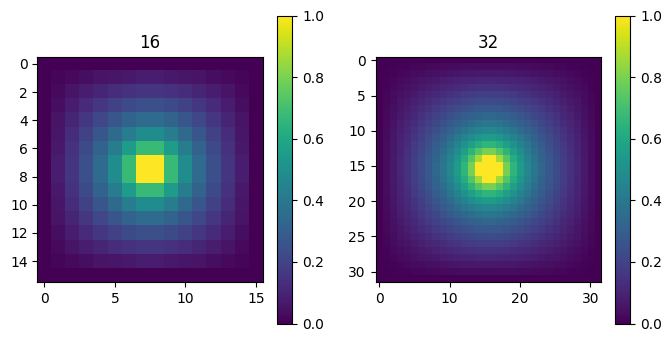

<Figure size 640x480 with 0 Axes>

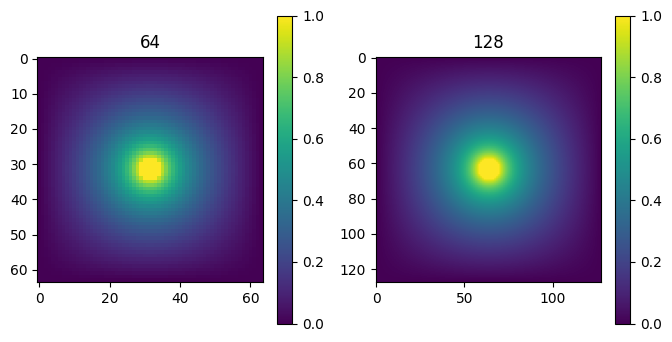

<Figure size 640x480 with 0 Axes>

<Figure size 800x400 with 0 Axes>

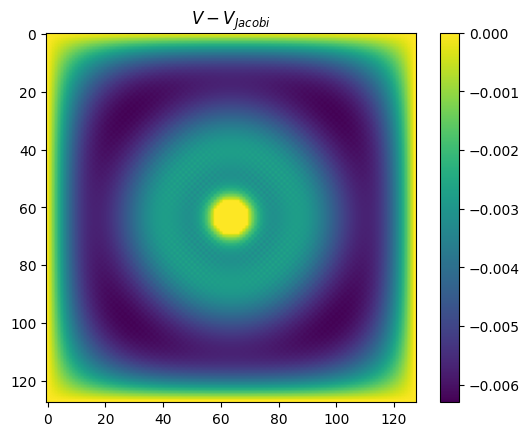

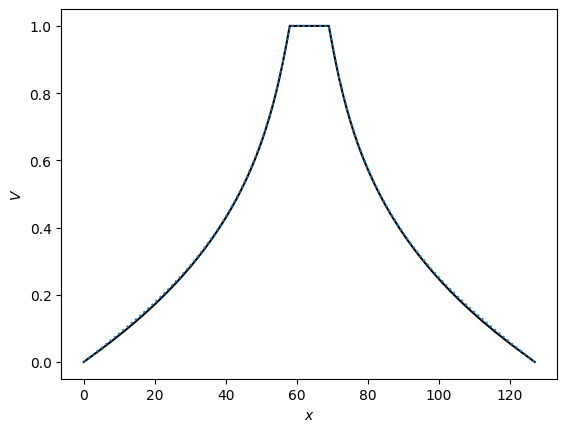

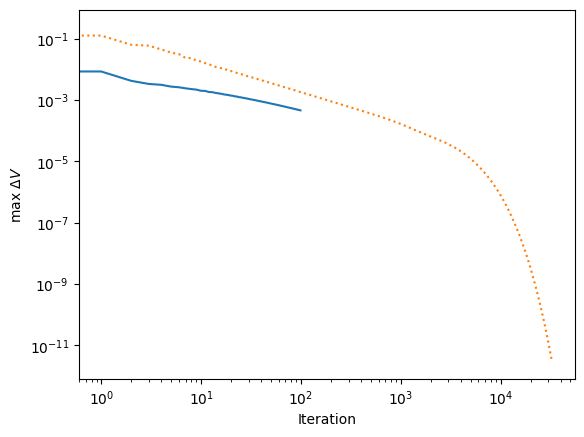

In [15]:
t0 = time.time()

n = 128
mask, bc = set_bcs(n)

# Initial guess for the potential
V0 = np.ones_like(bc) * 0.5

# First go down in resolution from fine to coarse
# and calculate the smoothed bc, mask and V arrays at each step
npass = 3
bcs = [bc,]
masks = [mask,]
Vs = [V0,]
for i in range(npass):
    bcs.append(deres(bcs[i]))
    masks.append(deres(masks[i]))
    Vs.append(deres(Vs[i]))

# Now step back up, relaxing at each stage    
for i in range(npass,0,-1):
    n0 = bcs[i].shape[0]
    Vs[i], deltaV = laplace(masks[i], bcs[i], 100, Vs[i], make_plot=False)
    print('n = %d, Delta V = %lg' % (n0, deltaV[-1],))
    Vs[i-1] = upres(Vs[i])

n0 = bcs[0].shape[0]
nn = 100 #n0*n0//10
Vs[0], deltaV = laplace(masks[0], bcs[0], nn, Vs[0], make_plot=False)
print('n = %d, Delta V = %lg' % (n0, deltaV[-1],))

print('Total time taken = %lg seconds' % (time.time()-t0,))

titles = ["%d" % (V.shape[0],) for V in Vs]
plot_matrices(Vs[::-1], nmax = 2, titles=titles[::-1])

plt.clf()
plt.title(r'$V-V_{Jacobi}$')
plt.imshow(Vs[0]-V_jacobi)
plt.colorbar()
plt.show()

plt.clf()
plt.plot(np.arange(n), Vs[0][int(n/2),:], 'k')
plt.plot(np.arange(n), V_jacobi[int(n/2),:], ':')
plt.ylabel(r'$V$')
plt.xlabel(r'$x$')
plt.show()

plt.clf()
plt.plot(np.arange(len(deltaV)), deltaV)
plt.plot(np.arange(len(deltaV_jacobi)), deltaV_jacobi, ':')
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'max $\Delta V$')
plt.xlabel('Iteration')
plt.show()